# Machine Learning Demonstration

To run this notebook, you need to install python dependencies:

Install tensorflow:

With conda:

```conda install -c conda-forge tensorflow```

With pip:

```pip install tensorflow```

> If you have a GPU in your computer, you can better install the gpu version to speed up some computations by following the instructions in this link: https://www.tensorflow.org/install/

Other dependencies:

With pip:

```pip install numpy==1.14.0
pip install pandas==0.20.3
pip install matplotlib==2.1.1
pip install Keras==2.0.9
pip install scikit_learn==0.19.1```

## Using AI Techniques to Forecast GNSS Disruptions

A Global Navigation Satellite System (GNSS) is a network of satellites providing geospatial positioning with global coverage. Such a network relies upon radio communications between satellites and ground-based receivers, which can be subject to interruptions in the presence of extreme space weather events.

Space weather refers to changes in radiation emitted by the Sun, leading to fluctuations in the Earth’s ionosphere. Changes to the electron density in the ionosphere cause fluctuations in the amplitude and phase of radio signals, known as phase scintillation. Radio signals propagating between GNSS satellites and ground-based receivers are affected by these scintillation events and can become inaccurate or even lost. 

In a society that has become dependent on GNSS services for navigation in everyday life, it is important to know when signal disruptions might occur. Given that space weather events occurring between the Sun and the Earth have a non-linear relationship, physical models have struggled to predict scintillation events. One solution is to use artificial intelligence (AI) technologies to create machine learning (ML) models. 

In this notebook, we examine the use of ML models to predict scintiallation events, using historical GNSS data. Initially, a support vector machine (SVM) was used to recreate the baseline model outlined in McGranaghan et al., 2018. We then implement a neural network model in an attempt to improve upon the baseline results. Both methods used the strength of kdb+/q to deal with time-series data and embedPy to import the necessary python ML libraries.


## Data

Publicly available data was used to develop the ML models discussed below. Different datasets describe the state of the Sun, the ionosphere and the magnetic field of the Earth. Combining these datasets created an overall picture of atmospheric conditions at each timestep, including when scintillation events occured.

The first dataset was collected by the Canadian High Arctic Ionospheric Network (CHAIN) from high-latitude GNSS receivers (login required - http://chain.physics.unb.ca/chain/pages/data_download). 14 CHAIN receiver stations with the most continuous data were used. The latitude and longitude of each PolaRxS station can be found on the CHAIN website  (http://chain.physics.unb.ca/chain/pages/stations/). Recorded features for each receiver include; TEC, differential TEC (current TEC minus TEC recorded 15 seconds previously), the scintillation index, the phase and amplitude scintillation indices and the phase spectral slope.

Solar and geomagnetic features can be found in the second dataset, which is available on the NASA OMNI database (ftp://spdf.gsfc.nasa.gov/pub/data/omni/). Features in the data include solar wind properties (velocity, power, and the Newell and Borovsky constants), magnetic properties (magnetic field strength, IMF and clock angle), and geomagnetic indices (AE and SymH), along with proton fluxes and solar X-ray measurements. Additional indices Kp and F10.7 are available from the NOAA Geostationary Satellite Server (https://satdat.ngdc.noaa.gov/sem/goes/data/full/).

The third dataset was collected by magnetometers at high latitudes in the Canadian Array for Real-time Investigations of Magnetic Activity Network (CARISMA) (http://data.carisma.ca/FGM/1Hz/).


## Preprocessing

Initial preprocessing can be found in the script preprocessing.q. CHAIN data was corrected for non-scintillation irregularities by only including data from satellites where lock-times with the receivers were greater than 200 seconds, and where elevation was above 30 degrees. The phase and amplitude scintillation indices were projected to the vertical, to correct for geomagnetic effects in measurements recorded at different elevations. Latitude and longitude for each station were also added to the data. Historical values recorded 15 and 30 minutes previously were included in the Solar dataset for each input parameter from the OMNI dataset.

For all three datasets, datetime columns were added. Solar data which was recorded in 5 and 60 minutes intervals. Given that CHAIN and magnetometer data were recorded at 1 minute intervals for each CHAIN receiver station, station columns were added to each and solar data was forward filled at the missing timesteps to allow consistency across the data.

Once preprocessed, data was persisted as a date-partitioned kdb+ database. Scripts were written to create configuration tables (configSVM.q and configNN.q), specifying the features and scaling required for each model.

## 1 SVM Baseline Model

A SVM will be used to recreate the baseline model outlined in McGranaghan et al., 2018. CHAIN and solar datasets from 2015 are used, with measurements recorded at 1 minute intervals, where CHAIN data is recorded for each of the 14 receiver stations.

### 1.1 Data

In [1]:
\c 12 110
\l /SpaceWeather/test
\l ../sw1/utils.q
\l ../sw1/graphics.q
\l ../sw1/configSVM.q

-1"SVM Configuration Table:\n";
show configSVM
-1"\nShape of chain is ",sv[" x "]string(count chain;count cols chain);
-1"Shape of solar is ",sv[" x "]string(count solar;count cols solar);

SVM Configuration Table:

table colname   feature scaler
------------------------------
chain dt        0       ::    
chain doy       0       ::    
chain cs        0       ::    
chain tec       1       ::    
chain dtec      1       ::    
chain SI        1       ::    
chain specSlope 1       ::    
..

Shape of chain is 28625805 x 82
Shape of solar is 2082240 x 35


In [ ]:
\c 12 110
\l /SpaceWeather/test
\l ../sw1/utils.q
\l ../sw1/graphics.q
\l ../sw1/configSVM.q

-1"SVM Configuration Table:\n";
show configSVM
-1"\nShape of chain is ",sv[" x "]string(count chain;count cols chain);
-1"Shape of solar is ",sv[" x "]string(count solar;count cols solar);
-1"Shape of goes is ",sv[" x "]string(count goes;count cols goes);
-1"Shape of mag is ",sv[" x "]string(count mag;count cols mag);

In [2]:
1"Selecting data from ",(sv[" - "]string(sdateSVM:2015.01.01;edateSVM:2015.12.31)),"\n\n";
show completeSVM:raze{[dt]
 `chain1`solar1 set'{({exec colname from configSVM where table=x}each y)#select from y where date=x}[dt;]each`chain`solar;
 select from(chain1 lj`dt xkey update solarmatch:1b from solar1)where solarmatch
 }peach sdateSVM+til 1+edateSVM-sdateSVM
-1"\nShape of merged chain and solar tables is ",sv[" x "]string shape completeSVM;

In [3]:
sdateSVM:2015.01.01
edateSVM:2015.01.02

1"Selecting data from ",sv[" - ";string sdateSVM,edateSVM],"\n\n";

getTabDate:{[dt;t]?[t;enlist(=;`date;dt);0b;{x!x}exec colname from configSVM where table=t]}
getAllDate:{[dt]
  r:tabs!getTabDate[dt]each tabs:`chain`solar`goes;
  t:select from(r[`chain]lj`dt xkey update match:1b from r`solar)where match; 
  select from(t lj`dt xkey update match:1b from r`goes)where match}
show completeSVM:raze getAllDate peach sdateSVM+til 1+edateSVM-sdateSVM

-1"\nShape of merged chain and solar tables is ",sv[" x "]string shape completeSVM;

### 1.2 Extra Features
Scintillation events are subject to seasonal variations. To account for this, the sine and cosine time of day and day of year were added to the data. For the baseline, only the cosine day of year is added.

$$\begin{eqnarray}
cosdoy = cos\Big(\frac{2 \pi doy}{D_{tot}}\Big), && sindoy = sin\Big(\frac{2 \pi doy}{D_{tot}}\Big)
\end{eqnarray}$$
$$ $$
$$\begin{eqnarray}
costime = cos\Big(\frac{2 \pi dt}{T_{tot}}\Big), && sintime = sin\Big(\frac{2 \pi dt}{T_{tot}}\Big)
\end{eqnarray}$$

where $doy$ is the day of year, $D_{tot}$ is the number of days in the year (365 for this model), $dt$ is the time in minutes and $T_{tot}$ is the number of minutes in a day. The feature names must be added to the configuration table, with relevant scaling, to allow for scaling at a later stage.

In [3]:
completeSVM:update cosdoy:cos 2*pi*doy%365 from completeSVM;
configSVM,:(`completeSVM;`cosdoy;1b;log1p);

### 1.3 Target Data
The occurrence of scintillation events are shown by sudden irregularities in a number of features, specifically the phase scintillation index, $\sigma_\phi$, which is projected to the vertical throughout this work (sigPhiVer). As the baseline looks at predicting scintillation 1 hour ahead, the value of $\sigma_\phi$ 1 hour ahead of the current timestep (sigPhiVer_1hr) was used as target data for the models.

Ideally, data would have been recorded for each CHAIN station, at every minute throughout 2015. However, receivers can experience faults which lead to timesteps with no recorded data. To examine where these gaps occur in the data, a list containing timesteps for 2015, with minute granularity, can be merged to the full data table, with target values plotted for each timestep.

In [4]:
/ import python libraries using embedPy
plt:   .p.import[`matplotlib]`:pyplot;
array: .p.import[`numpy][`:array];
svc:   .p.import[`sklearn.svm]`:SVC;

In [ ]:
completeSVM:{[t;hr]
   t lj 2!?[t;();0b;(`dt`cs,`$"sigPhiVer",string[hr],"hr")!((-;`dt;"u"$60*hr);`cs;`sigPhiVer)]
  }[completeSVM;1]

configSVM,:(`chain;`sigPhiVer1hr;0b;::)

Phase scintillation index per CHAIN station from 2015.01.01 - 2015.12.31



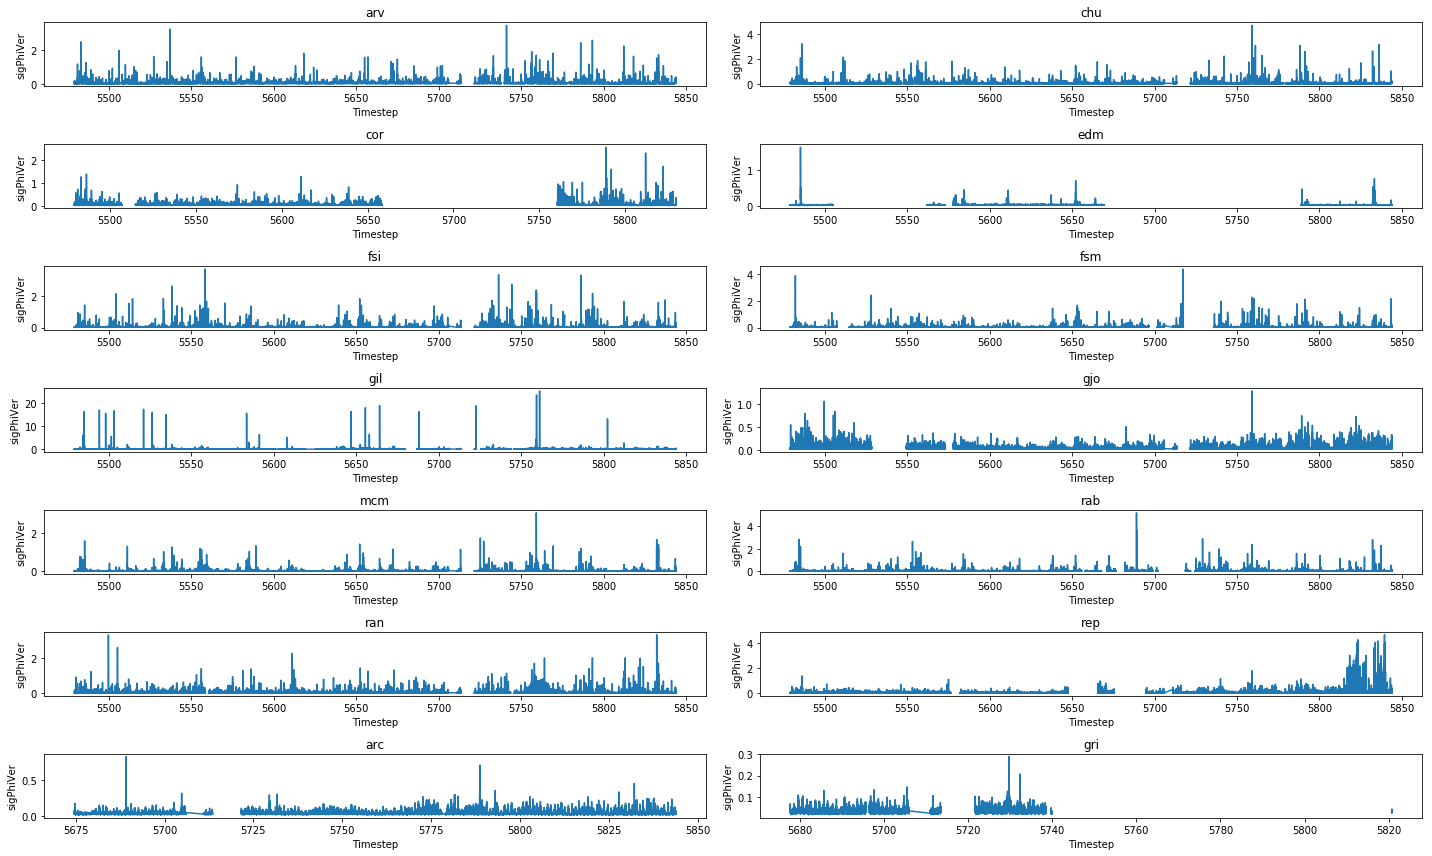

In [6]:
1"Phase scintillation index per CHAIN station from ",(sv[" - "]string(sdateSVM;edateSVM)),"\n\n";

plt[`:figure]`figsize pykw 20 12;
{ stn:(distinct completeSVM`cs)x;
  tab:exec dt,cs,sigPhiVer1hr from completeSVM where cs=stn;
  plt[`:subplot]. 7 2,x+1;
  plt[`:title]string stn:(distinct completeSVM`cs)x;
  plt[`:xlabel]"Timestep";
  plt[`:ylabel]"sigPhiVer";
  plt[`:plot][tab`dt;tab`sigPhiVer1hr];
 }each til 14;

plt[`:tight_layout][];
plt[`:show][];

### 1.4 Feature Engineering
To account for gaps in the data, rows containing nulls will be dropped. As ML models are sensitive to inputs with large ranges, some features in the input data were log(1+x) scaled (as defined in the SVM configuration table). All features will be standard scaled at a later stage, before feeding the data to the SVM classifier.

In [9]:
completeSVM@:where not any flip null completeSVM;
completeSVM:flip(exec first scaler by colname from configSVM)@'flip completeSVM;

-1"Scintillation events:\n";
show dist:update pcnt:round[;.01]100*num%sum num from select num:count i by scintillation from([]scintillation:.1<completeSVM`sigPhiVer1hr);
-1"\n",(string first exec pcnt from select pcnt from dist where scintillation)," percent of the target values represent scintillation occurring.";

Scintillation events:

scintillation| num     pcnt 
-------------| -------------
0            | 4304589 96.84
1            | 140503  3.16 

3.16 percent of the target values represent scintillation occurring.


### 1.5 Metrics
As only 3% of the data represented scintillation occuring, it would have been easy to create a model which produced high accuracy. A naive model which predicted that scintillation never occured would still have been correct 97% of the time. Additional metrics, including the total skill score (TSS) will be used to determine how well the models perform.
$$\begin{equation}TSS=\frac{TP}{TP+FN}-\frac{FP}{FP+TN}\end{equation}$$

where $TP$, $TN$, $FP$ and $FN$ are true positives, true negatives, false positives and false negatives respectively.

### 1.5 Model
Below, a total of 40,000 random data points will be selected. X data is selected according to the SVM configuration table and y data is sigmaPhiVer_1hr to allow 1 hour prediction. Standard scaling will be applied to x data to remove the mean and scale each feature to unit variance. Meanwhile, target data will be left unscaled and assigned a binary value.

When scintillation events take place, $\sigma_\phi$ will have a value which is greater than 0.1 radians. Therefore, target data will be assigned a value of 1 if greater than 0.1 radians (positive class) and 0 with a value below (negative class).

Initially, two sets of shuffled indices are produced, covering the full set of indices in the data. These indices will then be used to split x and y data into split into training (80%) and testing (20%) sets.

Once the model has been trained, it will be used to make predictions using test data. These predictions will be compared with y test values using a confusion matrix. The function will then output the resulting performance metrics.

In [10]:
\S 30

SVMmodel:{[configSVM;tab]
 
 sample:tab -40000?count select from tab;
 xdata:flip stdscaler each flip(exec colname from configSVM where feature)#sample;
 ydata:.1<exec sigPhiVer1hr from sample;
 `xtrn`ytrn`xtst`ytst set'raze(xdata;ydata)@\:/:splitIdx[.8 .2;xdata];

 start:.z.T;
 model:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
 model[`:fit][array[value flip xtrn]`:T;ytrn];
 -1"Training SVM model for a single station took ",string .z.T-start;
 
 pred:model[`:predict][array[value flip xtst]`:T]`; 
 metrics cfm[ytst;pred]

 }

In [ ]:
\S 30

SVMmodel:{[cfg;tab]
 
 sample:tab -40000?count select from tab;
 xdata:flip stdscaler each flip(exec colname from cfg where feature)#sample;
 ydata:.1<exec sigPhiVer1hr from sample;
 r:`xtrn`ytrn`xtst`ytst!raze(xdata;ydata)@\:/:splitIdx[.8 .2;xdata];

 start:.z.T;
 model:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
 model[`:fit][array[value flip r`xtrn]`:T;r`ytrn];
 -1"Training SVM model for a single station took ",string .z.T-start;
 
 pred:model[`:predict][array[value flip r`xtst]`:T]`; 
 metrics cfm[r`ytst;pred]

 }

### 1.6 All Stations (Baseline Model)
Train/predict using combined data from all stations.

In [11]:
resALL:(enlist[`cs]!enlist`ALL),SVMmodel[configSVM;completeSVM]

Training SVM model for a single station took 00:12:40.175


### 1.7 Individual Stations
Train/predict using data from each individual station.

In [9]:
stntab:`$(string stn:distinct completeSVM`cs),\:"tab";
stntab set'{delete cs from select from completeSVM where cs=x}each stn;
resIDV:([]cs:stn),'(SVMmodel[configSVM;]each stntab)

Training SVM model for a single station took 00:06:35.779
Training SVM model for a single station took 00:05:48.325
Training SVM model for a single station took 00:07:08.386
Training SVM model for a single station took 00:00:50.401
Training SVM model for a single station took 00:04:34.817
Training SVM model for a single station took 00:03:55.374
Training SVM model for a single station took 00:10:53.952
Training SVM model for a single station took 00:07:18.791
Training SVM model for a single station took 00:03:23.912
Training SVM model for a single station took 00:04:27.649
Training SVM model for a single station took 00:06:58.355
Training SVM model for a single station took 00:10:52.456
Training SVM model for a single station took 00:06:07.096
Training SVM model for a single station took 00:00:34.935


In [ ]:
stntab:`$(string stn:distinct completeSVM`cs),\:"tab";
idvData:stntab!{delete cs from select from completeSVM where cs=x}each stn;
resIDV:([]cs:stn),'(SVMmodel[configSVM;]each idvData)

### 1.8 Fort McMurray Station
Train the model using data from the Fort McMurray (mcm) station.

In [10]:
\S 20
mcmdata:mcmtab -32000?count mcmtab;
xtrnmcm:flip stdscaler each flip(exec colname from configSVM where feature)#mcmdata;
ytrnmcm:.1<exec sigPhiVer1hr from mcmdata;

start:.z.T;
mcmmodel:svc[`kernel pykw`rbf;`C pykw .1;`gamma pykw .01;`class_weight pykw enlist[1]!enlist 50;`probability pykw 1b];
mcmmodel[`:fit][array[value flip xtrnmcm]`:T;ytrnmcm];
-1"Training SVM model for mcm took ",string .z.T-start;

Training SVM model for mcm took 00:03:35.920


Predict using data from the remaining stations.

In [11]:
mcmpred:{[configSVM;stn]
 sample:stn -8000?count select from stn;
 xtst:flip stdscaler each flip(exec colname from configSVM where feature)#sample;
 ytst:.1<exec sigPhiVer1hr from sample;
 pred:mcmmodel[`:predict][array[value flip xtst]`:T]`;
 metrics cfm[ytst;pred]
 }

start:.z.T;
resMCM:([]cs:stn except `mcm),'(mcmpred[configSVM;]each stntab except `mcmtab);
-1"Making predictions using SVM model for mcm took ",string .z.T-start;
`cs xasc`resMCM upsert select from resIDV where cs=`mcm;

Making predictions using SVM model for mcm took 00:01:17.191


### 1.9 Results - 1 Hour Prediction

In [12]:
\c 200 110
\P 4
-1"Prediction results for SVM:\n";
show results:flip resALL,'flip resIDV
-1"\n\nPrediction results for SVM trained on Fort McMurray (mcm) station:\n";
show resMCM

Prediction results for SVM:

chainStation accuracy errorRate precision recall specificity TSS    
--------------------------------------------------------------------
ALL          73.04    26.96     9.512     83.15  72.69       0.5583 
arv          81.46    18.54     7.331     73.08  81.63       0.5471 
chu          84.5     15.5      6.789     83.18  84.52       0.677  
cor          72.69    27.31     6.664     84.62  72.41       0.5703 
edm          97.65    2.35      21.28     94.34  97.67       0.9201 
fsi          86.55    13.45     10.03     81.82  86.64       0.6845 
fsm          87.84    12.16     7.949     69.83  88.1        0.5793 
gil          20.91    79.09     13.65     99.7   9.618       0.09319
gjo          71.64    28.36     11.56     89.57  70.88       0.6045 
mcm          86.54    13.46     13.89     93.99  86.36       0.8035 
rab          84.78    15.22     8.855     82.86  84.81       0.6767 
ran          76.74    23.26     7.285     77.72  76.71       0.5443 
rep  

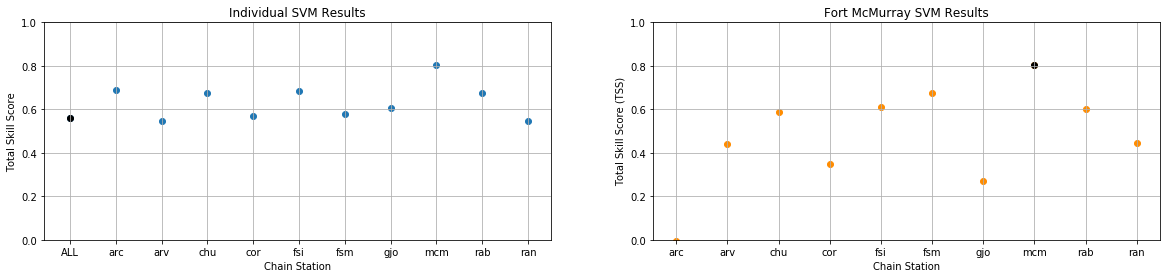

In [13]:
/remove sparse stations and plot
res:`svmresults`mcmresults!{select from x where cs<>`edm,cs<>`gil,cs<>`gri,cs<>`rep}each(results;resMCM);
resplot[res`svmresults;res`mcmresults;`mcm];

The baseline model which combines data from all CHAIN stations gives a relatively average accuracy of 73.04%. However, this model produces a low TSS of 0.56 (precision = 9.51%, recall = 83.15%). The above plots contain TSS values for the different methods used. The left plot shows how the performance of the model varied depending on which station was used to train and test the SVM. The Fort McMurray (mcm) model shown on the right produces worse results, with results varying even more drastically from station to station.

From these results we can infer that scintillation events must be localized. To train a model with higher accuracy and TSS, data must either be separated on a station-by-station basis, or additional spatial parameters must be introduced to account for the geospatial elements in the data.

### 1.10 Results - Multiple Prediction Times
Until this point, the SVM model has been used to predict scintillation events 1 hour ahead. However, it is possible to predict at any chosen prediction time. Using the same model as above, random samples of 40,000 timesteps from 2015 were selected for each station to train/test the model at multiple prediction times.
<img src="../sw1/predtimes.png">
As expected, the TSS results above show that the model tends to perform better at 30 minute and 1 hour prediction times, with results getting worse as the prediction time increases. Accuracy follows the same trend, decreasing as prediction time increases (shown below). The Fort McMurray (mcm) station gives the highest TSS overall, allowing the model to predict 24 hours ahead with 73% accuracy and 0.61 TSS.
<img src="../sw1/predtimesacc.png"> 

## 2 Neural Network (NN) Model
To improve performance metrics, data from 2015-2017 was used to train a neural network model. Going forward, only components selected in the feature selection process (featureselection.ipynb) will be used (found in the NN configuration table).

As results showed that scintillation events are localized, localized features will be added to the dataset to account for the position of each station. These included the magnetometer dataset along with additional features mentioned below.
### 2.1 Data

In [2]:
\c 12 110
\l ../sw1/configNN.q

In [3]:
1"Selecting data from ",(sv[" - "]string(sdateNN:2015.01.01;edateNN:2017.12.31)),"\n\n";
start:.z.T;
show completeNN:raze{[dt]
 `chain1`solar1`mag1 set'{({exec colname from configNN where table=x}each y)#select from y where date=x}[dt;]each`chain`solar`mag;
 merged:select from(chain1 lj`dt xkey update solarmatch:1b from solar1)where solarmatch;
 select from(merged lj`dt`chainStation xkey update magmatch:1b from mag1)where magmatch
 }peach sdateNN+til 1+edateNN-sdateNN
-1"\nReading in data with shape ",(sv[" x "]string shape completeNN)," took ",string .z.T-start;

Selecting data from 2015.01.01 - 2015.01.02

dt                      doy chainStation TECcurrent dTEC_15s SI    specSlope S4ver      sigPhiVer  sigPhiVe..
-----------------------------------------------------------------------------------------------------------..
2015.01.01T00:01:00.000 1   chu          31.749     0        0.008 1.86      0.03101697 0.02482456 0.024799..
2015.01.01T00:02:00.000 1   chu          29.798     -0.006   0.009 1.94      0.03004769 0.02475049 0.023067..
2015.01.01T00:03:00.000 1   chu          34.463     -0.014   0.01  1.87      0.03102507 0.02451099 0.022277..
2015.01.01T00:04:00.000 1   chu          29.76      -0.012   0.009 1.89      0.03066638 0.02402253 0.030145..
2015.01.01T00:05:00.000 1   chu          29.046     -0.014   0.009 1.86      0.03357262 0.02608416 0.021976..
2015.01.01T00:06:00.000 1   chu          28.579     0.01     0.008 1.9       0.02861928 0.02788307 0.019836..
2015.01.01T00:07:00.000 1   chu          29.122     0.011    0.007 1.89    

In [ ]:
sdateNN:2015.01.01
edateNN:2017.12.31

1"Selecting data from ",sv[" - ";string sdateNN,edateNN],"\n\n";

getTabDate:{[dt;t]?[t;enlist(=;`date;dt);0b;{x!x}exec colname from configNN where table=t]}
getAllDate:{[dt]
  r:tabs!getTabDate[dt]each tabs:`chain`solar`goes`mag;
  t1:select from(r[`chain]lj`dt xkey update match:1b from r`solar)where match
  t2:select from(t1 lj`dt xkey update match:1b from r`goes)where match;
  select from(t2 lj`dt`cs xkey update match:1b from r`mag)where match}
show completeNN:raze getAllDate peach sdateNN+til 1+edateNN-sdateNN

-1"\nShape of merged chain, solar and mag tables is ",sv[" x "]string shape completeNN;

### 2.2 Extra Features
As mentioned above, extra columns sindoy, cosdoy, sintime and cosdoy were added to account for variations in the data. In this model, 365.25 is used for $D_{tot}$ to account for the extra day present in a leap year. The names of the new features are added to the NN configuration table to account for scaling at a later stage. 

In [5]:
a:{2*pi*x%365.25};
b:{(2*pi*`int$`minute$x)%1440};
completeNN:update sindoy:sin a[doy],cosdoy:cos a[doy],sintime:sin b[dt],costime:cos b[dt]from completeNN;
{configNN,:(x;y;1b;z)}'[4#`completeNN;`sindoy`cosdoy`sintime`costime;(log1p;log1p;(::);(::))];

When a scintillation event occurs, geomagnetic features such as xcomp, ycomp, zcomp and dTEC_15s will fluctuate drastically, shown in the plot below. 

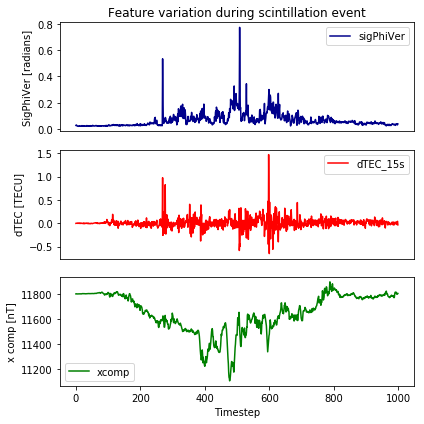

In [6]:
scintplot[select from completeNN where cs=`mcm]

It is therefore useful to give more importance to these features by adding columns which contain their absolute values with the mean removed.

In [7]:
newval:{abs(x-avg x)};
completeNN:update newx:newval x,newy:newval y,newz:newval z,newdtec:newval dtec from completeNN;
{configNN,:(x;y;1b;z)}'[4#`completeNN;`newx`newy`newz`newdtec;4#(::)];

### 2.3 Feature Engineering
Following the same method as the SVM model, nulls will be dropped, with features selected and standard scaled. For the NN model, features will be exponentially weighted to give more recent data the highest importance. Target data will also be log scaled to prevent negative predictions for $\sigma_\phi$, which is always positive. A train-test split of 80%-20% will again be used.

In [8]:
\S 94
completeNN@:where not any flip null completeNN;
scaled:flip(exec first scaler by colname from configNN)@'flip completeNN;
xdata:flip stdscaler each flip(exec colname from configNN where feature)#scaled;
xdata:flip(reverse ema[.1]reverse@)each flip xdata;
ydata:log exec sigPhiVer1hr from completeNN;
`xtrn`ytrn`xtst`ytst set'raze(xdata;ydata)@\:/:splitIdx[.8 .2;xdata];

In [ ]:
\S 94
completeNN@:where not any flip null completeNN;
scaled:flip(exec first scaler by colname from configNN)@'flip completeNN;
xdata:flip stdscaler each flip(exec colname from configNN where feature)#scaled;
xdata:flip(reverse ema[.1]reverse@)each flip xdata;
ydata:log exec sigPhiVer1hr from completeNN;
r:`xtrn`ytrn`xtst`ytst!raze(xdata;ydata)@\:/:splitIdx[.8 .2;xdata];

To overcome the small fraction of data representing scintillation events, oversampling is used on the training set. A random sample taken from the positive class and re-added to the training dataset, giving a final training set with 50% positive samples.

In [9]:
\S 95
positiveIdx:where yscint:.1<exp ytrn;
`xpositive`ypositive set'{x[y]}[;positiveIdx]each(xtrn;ytrn);
sampleIdx:(nadd:(-) . sum each yscint=/:(0 1))?count xpositive;
`xsample`ysample set'{x[y]}[;sampleIdx]each(xpositive;ypositive);
`xoversampled`yoversampled set'(xtrn;ytrn),'(xsample;ysample);

-1"Scintillation events before oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:yscint);
-1"\nScintillation events after oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:.1<exp yoversampled);

Scintillation events before oversampling:

ybinary| num     pcnt 
-------| -------------
0      | 4325747 88.44
1      | 565260  11.56

Scintillation events after oversampling:

ybinary| num     pcnt
-------| ------------
0      | 4325747 50  
1      | 4325747 50  


In [ ]:
\S 95
positiveIdx:where yscint:.1<exp r`ytrn;
pos:`x`y!{x[y]}[;positiveIdx]each(r`xtrn;r`ytrn);
sampleIdx:(nadd:(-) . sum each yscint=/:(0 1))?count pos`x;
sample:`x`y!{x[y]}[;sampleIdx]each(pos`x;pos`y);
oversampled:`x`y set'(r`xtrn;r`ytrn),'(sample`x;sample`y);

-1"Scintillation events before oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:yscint);
-1"\nScintillation events after oversampling:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by ybinary from([]ybinary:.1<exp oversampled`y);

### 2.4 Model
We can use embedPy to import the python libraries necessary for creating the NN.

In [11]:
sequential:    .p.import[`keras.models]`:Sequential;
dense:         .p.import[`keras.layers]`:Dense;
normalization: .p.import[`keras.layers]`:BatchNormalization;
pylist:        .p.import[`builtins]`:list;

The model has 1 input layer, 4 hidden layers and 1 output layer. A normal distribution is used as the initializer for the kernel to set the weights in each layer of the model.

The input and hidden layers use 256 nodes, along with an Exponential Linear Unit (ELU) activation function, which gives the best model performance. ELU was specifically chosen as it converged the loss function to zero better than other activation functions, such as a Rectified Linear Unit (RELU).

The output layer has 1 node and a linear activation function to allow a single value for $\sigma_\phi$ to be returned for each timestep.

In [13]:
model:sequential[];
model[`:add]dense[256;`input_dim pykw 37;`kernel_initializer pykw`normal;`activation pykw`elu];
model[`:add]normalization[];
model[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
model[`:add]normalization[];
model[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
model[`:add]normalization[];
model[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
model[`:add]normalization[];
model[`:add]dense[256;`activation pykw`elu;`kernel_initializer pykw`normal];
model[`:add]normalization[];
model[`:add]dense[1;`activation pykw`linear];
model[`:compile][`loss pykw`mean_squared_error;`optimizer pykw`adam;`metrics pykw pylist `mse`mae]; 

We can now train the model for 50 epochs, using batch sizes of 512 each time. The model performs validation using 20% of the training data.

In [14]:
epochs:50;
batchsz:512;
start:.z.T;
resNN:model[`:fit][array[value flip xoversampled]`:T;yoversampled;`batch_size pykw batchsz;`verbose pykw 0;`epochs pykw epochs;`validation_split pykw .2];
-1"Training sequential model for ",string[epochs]," epochs took ",string .z.T-start;

Training sequential model for 50 epochs took 03:23:56.488


In [ ]:
epochs:50;
batchsz:512;
start:.z.T;
resNN:model[`:fit][array[value flip oversampled`x]`:T;oversampled`y;`batch_size pykw batchsz;`verbose pykw 0;`epochs pykw epochs;`validation_split pykw .2];
-1"Training sequential model for ",string[epochs]," epochs took ",string .z.T-start;

Once trained, the model can be used to make predictions 1 hour ahead. Outputs will be assigned binary values, using the 0.1 radians threshold, and can then be compared to the y test values selected previously.

In [15]:
predNN:raze(model[`:predict]array[value flip xtst]`:T)`;
value`predVal`binpredVal!(exp predNN;.1<exp predNN)

0.03173575 0.02438239 0.02638912 0.7854622 0.03012622 0.02022262 0.02345014 0.02335906 0.04807304 0.1111144..
0          0          0          1         0          0          0          0          0          1        ..


In [ ]:
predNN:raze(model[`:predict]array[value flip r`xtst]`:T)`;
value`predVal`binpredVal!(exp predNN;.1<exp predNN)

### 2.5 Results - 1 Hour Prediction
The model was trained and tested using combined data from the Fort Churchill (chu), Fort McMurray (mcm) and Fort Simpson (fsi) stations, each co-located magnetometer data. The true and false positives and negatives predicted by the model were represented in a confusion matrix.

In [ ]:
-1"\nConfusion matrix for neural network model:\n";
cfnM:cfm[.1<exp r`ytst;.1<exp predNN];
displayCM[value cfnM;`NoScintillation`Scintillation;"Confusion Matrix";()]


Confusion matrix for neural network model:



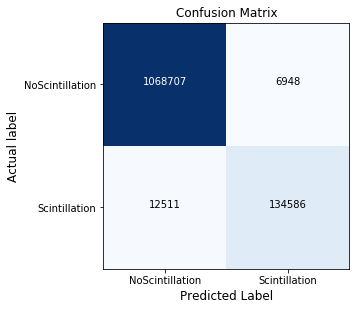

In [16]:
-1"\nConfusion matrix for neural network model:\n";
cfnM:cfm[.1<exp ytst;.1<exp predNN];
displayCM[value cfnM;`NoScintillation`Scintillation;"Confusion Matrix";()]

The NN correctly identified 134,586 scintillation events at 1 hour prediction time. To allow comparison with the SVM models, we can run the model for each individual station at 1 hour prediction time. Results are shown below.

In [25]:
-1"Results for neural network model:\n";
\P 4
resultsALL:(`model`cs!`NN`ALL),metrics cfnM;
nnresults:resultsALL,raze{("SSFFFFFF";(),",")0: x}each(`:../sw1/restabmcm.csv;`:../sw1/restabfsi.csv;`:../sw1/restabchu.csv);
show res1hr:`cs xasc raze({(enlist[`model]!enlist `SVM),exec from results where cs=x}each`ALL`mcm`fsi`chu;nnresults)

Results for neural network model:

model chainStation accuracy errorRate precision recall specificity TSS   
-------------------------------------------------------------------------
SVM   ALL          73.04    26.96     9.512     83.15  72.69       0.5583
NN    ALL          98.41    1.591     91.49     95.09  98.84       0.9393
SVM   chu          84.5     15.5      6.789     83.18  84.52       0.677 
NN    chu          98.63    1.375     48.26     78.49  98.89       0.7739
SVM   fsi          86.55    13.45     10.03     81.82  86.64       0.6845
NN    fsi          98.89    1.105     51.58     71.17  99.22       0.7039
SVM   mcm          86.54    13.46     13.89     93.99  86.36       0.8035
NN    mcm          99.02    0.9849    65.32     78.01  99.35       0.7736


It is evident that the NN method performs much better than the SVM model. Accuracy for all four models has increased to over 98%, while TSS has increased to greater than 0.7. Precision and recall are also high throughout, showing good performance. This is an impressive result, given that for the NN model 3 years of data has been used to train/test the model, compared to the 40,000 data points used in the SVM model.

Another means of determining how well the model performs is to plot true and predicted values together. Below, values for $\sigma_\phi$ at 1 hour prediction time are plotted for the combined NN model.

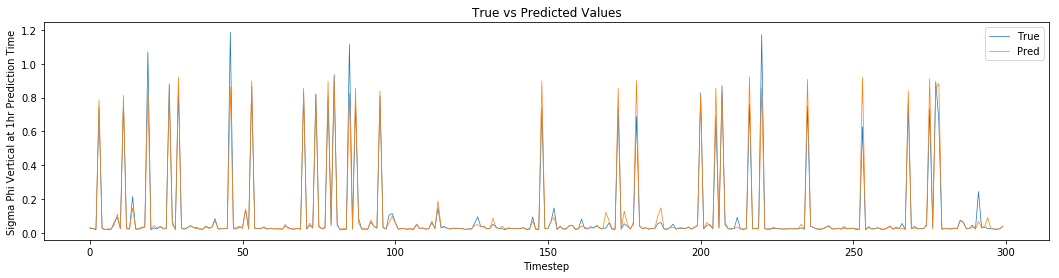

In [26]:
plt[`:figure]`figsize pykw 18 4;
plt[`:plot][300#exp ytst;`label pykw`True;`lw pykw .7];
plt[`:plot][300#exp predNN;`label pykw`Pred;`lw pykw .7];
plt[`:ylabel]"Sigma Phi Vertical at 1hr Prediction Time";
plt[`:xlabel]"Timestep";
plt[`:title]"True vs Predicted Values";
plt[`:legend][];
plt[`:show][];

The plot shows just how well the model predicts the target values. This is emphasized in the ROC curve below, where there is an area under the curve of 0.9972.

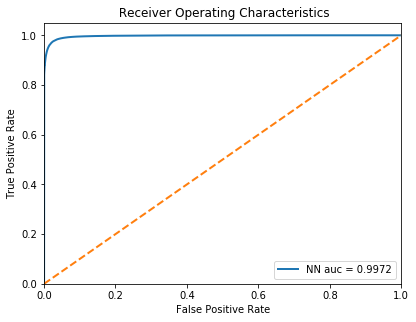

In [27]:
rocplot[ytst;predNN]

### 2.6 Results - Multiple Prediction Times
Similarly to the SVM, the NN model can be used to predict scintillation events from 30 minutes - 24 hours ahead. TSS score for each prediction are shown below.
<img src="../sw1/multipredTSS.png">
Unlike the SVM model, predictions made using the neural network model produced high values for TSS regardless of prediction time, with all values sitting above 0.67. The combined model produced the highest TSS throughout, with a value of 0.94. For prediction time 24 hours, TSS results have increased by an average of 0.39 in comparison to the SVM model, with all values now sitting above 0.73. This impressive compared to the baseline model where results became less reliable as the prediction time increased.
<img src="../sw1/multipredacc.png">
The accuracy results for each of the neural network models were also improved. Each model produces an accuracy of greater than 98% regardless of the prediction time. This is a vast improvement on the baseline model. Comparing accuracy at 24 hour prediction time gives an average increase of 27%.